In [22]:
from langgraph.graph import StateGraph,START,END
from typing import TypedDict,Annotated
import os
from langchain_google_genai import ChatGoogleGenerativeAI  
from dotenv import load_dotenv
from pydantic import BaseModel, Field
import operator

In [9]:
load_dotenv()

True

In [10]:
def create_llm():
    api_key=os.getenv("GOOGLE_API_KEY")

    llm=ChatGoogleGenerativeAI(model="gemini-1.5-flash",
                               api_key=api_key)
    
    return llm

In [11]:
model=create_llm()

In [16]:
class Schema(BaseModel):

    feedback:str=Field(description="Detailed Feedback for the essay")
    score:int=Field(description='Score out of 10',le=10,ge=0)

In [17]:
structured_output=model.with_structured_output(Schema)

In [18]:
essay="""
Artificial Intelligence (AI) has emerged as one of the most transformative technologies of the 21st century. Across the globe, nations are racing to harness its potential, and India is no exception. Over the past decade, India has witnessed a remarkable rise in the adoption, research, and development of AI, influencing sectors ranging from healthcare and agriculture to finance, education, and governance. This rise is not just about technological advancement, but also about redefining the country’s socio-economic landscape.

Early Adoption and Government Initiatives

The Indian government has recognized AI as a crucial driver of growth and innovation. In 2018, NITI Aayog launched the National Strategy for Artificial Intelligence, focusing on areas like healthcare, agriculture, education, smart cities, and mobility. Programs like Digital India and Startup India have further accelerated the adoption of AI by providing infrastructure, funding, and innovation platforms for startups and researchers. Additionally, AI is being integrated into governance through projects such as facial recognition systems, AI-powered grievance redressal platforms, and predictive analytics in policymaking.

Industry and Startup Ecosystem

India has become a hub for AI-driven startups, with Bengaluru, Hyderabad, and Pune emerging as major innovation centers. Companies are developing solutions in fields like fintech, edtech, and agritech, addressing India’s unique challenges. For instance, AI applications in agriculture help farmers with crop monitoring, weather prediction, and pest control, while fintech startups use AI to improve fraud detection and personalized banking services. Multinational corporations have also established AI research labs in India, tapping into the country’s vast pool of skilled engineers and data scientists.

Impact on Key Sectors

AI is transforming critical sectors of the Indian economy. In healthcare, AI is used for early disease detection, telemedicine, and drug discovery. In education, personalized learning platforms and AI-driven assessments are helping bridge gaps in quality and accessibility. Transportation and urban planning are benefiting from AI-based traffic management and smart city projects. Even traditional industries like manufacturing are leveraging AI-powered automation and robotics to improve efficiency.

Challenges and Concerns

Despite the rapid growth, challenges remain. A significant digital divide exists between urban and rural India, limiting the equitable benefits of AI. Ethical concerns such as data privacy, job displacement due to automation, and algorithmic biases also need careful consideration. Furthermore, there is a shortage of advanced AI research infrastructure and faculty, which hampers innovation compared to global leaders like the US and China.

The Road Ahead

For India to fully realize the potential of AI, there must be a balance between innovation and regulation. Investments in AI education, research, and digital infrastructure are essential. Collaboration between government, academia, and industry can foster sustainable AI ecosystems. With its large population, growing digital economy, and a vibrant talent base, India is well-positioned to become a global leader in responsible AI development.

Conclusion

The rise of AI in India is not merely a technological trend; it is a socio-economic revolution. From empowering farmers to enabling doctors and improving governance, AI has the potential to bridge gaps and accelerate inclusive growth. If India continues to embrace innovation while addressing challenges responsibly, it can transform itself into a global hub for AI, driving progress not only for its citizens but also for the world.
"""

In [20]:
prompt=f"Evaluate the language Quality of the Following Essay and provide a Feedback and assign a score out of 10:\n\n{essay}"
structured_output.invoke(prompt).score

8

In [36]:
class UPSC(TypedDict):
    essay:str
    language_feedback:str
    analysis_feedback:str
    clarity_feedback:str
    overall_feedback:str
    individual_scores:Annotated[list[int],operator.add]
    avg_score:float

In [68]:
def evaluate_language(state:UPSC)->UPSC:
    prompt=f"Evaluate the language Quality of the Following Essay and provide a Feedback and assign a score out of 10:\n\n{state['essay']}"
    result=structured_output.invoke(prompt)
    # state['language_feedback']=result.feedback
    # state['individual_scores']=state['individual_scores'].append(result.score)
    return {'language_feedback':result.feedback,
            'individual_scores':[result.score]}

In [69]:
def evaluate_analysis(state:UPSC)->UPSC:
    prompt=f"Evaluate the analytical Quality of the Following Essay and provide a Feedback and assign a score out of 10:\n\n{state['essay']}"
    result=structured_output.invoke(prompt)
    # state['analysis_feedback']=result.feedback
    # state['individual_scores']=state['individual_scores'].append(result.score)
    return {'analysis_feedback':result.feedback,
            'individual_scores':[result.score]}

In [70]:
def evaluate_thoughts(state:UPSC)->UPSC:
    prompt=f"Evaluate the clarity of thoughts in the Following Essay and provide a Feedback and assign a score out of 10:\n\n{state['essay']}"
    result=structured_output.invoke(prompt)
    # state['clarity_feedback']=result.feedback
    # state['individual_scores']=state['individual_scores'].append(result.score)
    return {'clarity_feedback':result.feedback,
            'individual_scores':[result.score]}

In [72]:
def final_evaluation(state: UPSC):

    # summary feedback
    prompt = f'Based on the following feedbacks create a summarized feedback \n language feedback - {state["language_feedback"]} \n depth of analysis feedback - {state["analysis_feedback"]} \n clarity of thought feedback - {state["clarity_feedback"]}'
    overall_feedback = model.invoke(prompt).content

    # avg calculate
    avg_score = sum(state['individual_scores'])/len(state['individual_scores'])

    return {'overall_feedback': overall_feedback, 'avg_score': avg_score}

In [73]:
graph=StateGraph(UPSC)

graph.add_node('evaluate_language',evaluate_language)
graph.add_node('evaluate_analysis',evaluate_analysis)
graph.add_node('evaluate_thoughts',evaluate_thoughts)
graph.add_node('final_evaluation',final_evaluation)

graph.add_edge(START,'evaluate_language')
graph.add_edge(START,'evaluate_analysis')
graph.add_edge(START,'evaluate_thoughts')
graph.add_edge('evaluate_language','final_evaluation')
graph.add_edge('evaluate_analysis','final_evaluation')
graph.add_edge('evaluate_thoughts','final_evaluation')


workflow=graph.compile()

In [74]:
initial_state={'essay':essay}

result=workflow.invoke(initial_state)

print(result)

{'essay': '\nArtificial Intelligence (AI) has emerged as one of the most transformative technologies of the 21st century. Across the globe, nations are racing to harness its potential, and India is no exception. Over the past decade, India has witnessed a remarkable rise in the adoption, research, and development of AI, influencing sectors ranging from healthcare and agriculture to finance, education, and governance. This rise is not just about technological advancement, but also about redefining the country’s socio-economic landscape.\n\nEarly Adoption and Government Initiatives\n\nThe Indian government has recognized AI as a crucial driver of growth and innovation. In 2018, NITI Aayog launched the National Strategy for Artificial Intelligence, focusing on areas like healthcare, agriculture, education, smart cities, and mobility. Programs like Digital India and Startup India have further accelerated the adoption of AI by providing infrastructure, funding, and innovation platforms for 

In [75]:
print(result['essay'])


Artificial Intelligence (AI) has emerged as one of the most transformative technologies of the 21st century. Across the globe, nations are racing to harness its potential, and India is no exception. Over the past decade, India has witnessed a remarkable rise in the adoption, research, and development of AI, influencing sectors ranging from healthcare and agriculture to finance, education, and governance. This rise is not just about technological advancement, but also about redefining the country’s socio-economic landscape.

Early Adoption and Government Initiatives

The Indian government has recognized AI as a crucial driver of growth and innovation. In 2018, NITI Aayog launched the National Strategy for Artificial Intelligence, focusing on areas like healthcare, agriculture, education, smart cities, and mobility. Programs like Digital India and Startup India have further accelerated the adoption of AI by providing infrastructure, funding, and innovation platforms for startups and res

In [76]:
print(result['individual_scores'])

[8, 8, 8]


In [77]:
print(result['avg_score'])

8.0


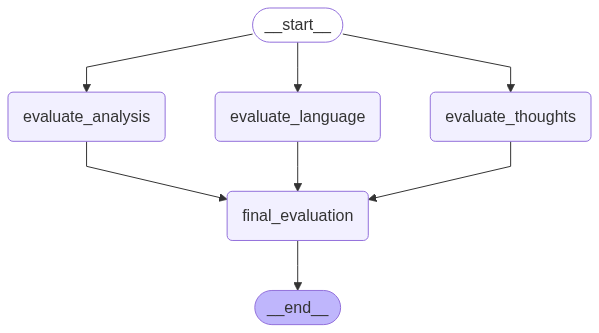

In [31]:
from IPython.display import Image, display

try:
    display(Image(workflow.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass